In [ ]:
!pip install --quiet langchain langchain-openai langchain-community deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.5 MB/s eta 0:00:00


## **Sistema Colaborativo (multi-agente) para el Análisis de Datos e Historia**

Este notebook implementa un sistema de colaboración de múltiples agentes que combina la investigación histórica con el análisis de datos para responder preguntas históricas complejas. Aprovecha el poder de los modelos de lenguaje grandes para simular que agentes especializados trabajan juntos para brindar respuestas integrales.

### Motivación
El análisis histórico a menudo requiere tanto una comprensión contextual profunda como una interpretación de datos cuantitativos. Al crear un sistema que combina estos dos aspectos, nuestro objetivo es brindar respuestas más sólidas y perspicaces a preguntas históricas complejas. Este enfoque imita la colaboración del mundo real entre historiadores y analistas de datos, lo que potencialmente conduce a perspectivas históricas más matizadas y basadas en datos.

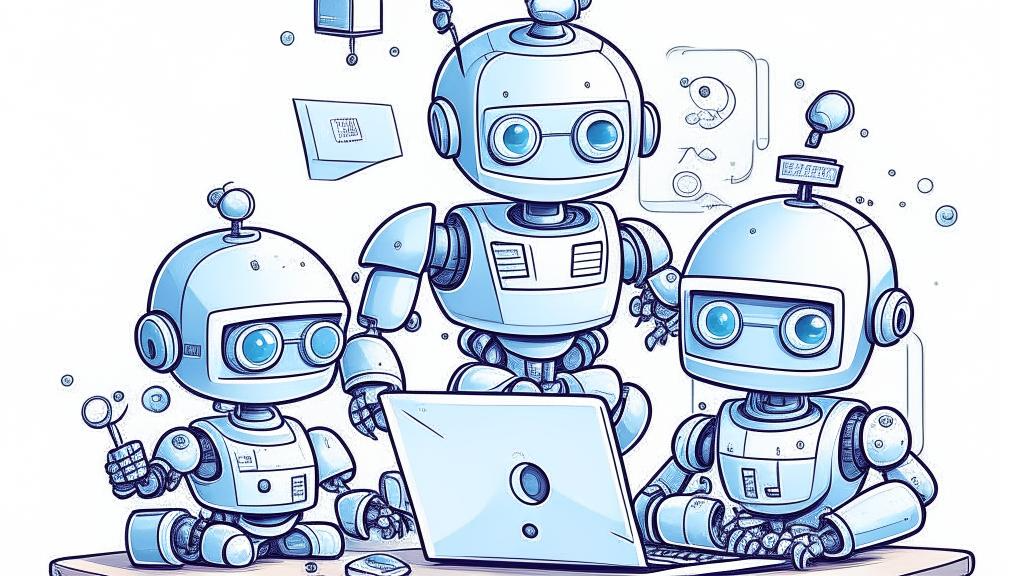

## Componentes clave
1. **Clase de agente**: una clase base para crear agentes de IA especializados.

2. **HistoricalResearchAgent**: especializado en contexto y tendencias históricas.

3. **DataAnalysisAgent**: centrado en la interpretación de datos numéricos y estadísticas.

4. **HistoricalDataCollaborationSystem**: organiza la colaboración entre agentes.

## Detalles del método
El sistema (workflow) sigue estos pasos:

1. **Contexto histórico**: el agente de historia proporciona antecedentes históricos relevantes.

2. **Identificación de las necesidades de datos**: el agente de datos determina qué información cuantitativa se necesita.

3. **Suministro de datos históricos**: el agente de datos históricos proporciona datos históricos relevantes.

4. **Análisis de datos**: el agente de datos interpreta los datos históricos proporcionados.

5. **Síntesis final**: el agente de datos históricos combina todos los conocimientos en una respuesta integral.

Este proceso iterativo permite un intercambio entre el contexto histórico y el análisis de datos, imitando la investigación colaborativa del mundo real.

In [ ]:
import os
from google.colab import userdata
import time
from IPython.display import display, Markdown
from typing import List, Dict
from deep_translator import GoogleTranslator

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain.memory import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

### Inicializar el modelo de lenguaje

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

model = ChatOpenAI(model="gpt-4o-mini")

# Test LLM
response = model.invoke("Tell me a joke about data scientists")
print(response.content)

Why did the data scientist bring a ladder to work?

Because they wanted to reach new heights in their analysis!


---

### Definir la clase base del Agente

Esta clase *Agent* permite crear un agente que puede procesar tareas basándose en su nombre, rol y habilidades. El método process construye un contexto de conversación, invoca un modelo de lenguaje con ese contexto y devuelve una respuesta adecuada.

In [ ]:
class Agent:

    TEMPLATE = """You are {name}, a {role}. Your skills include: {skills}.

    Previous conversation history:
    {chat_history}

    Human: {task}
    Chatbot:"""

    def __init__(self, name: str, role: str, skills: List[str]):
        self.name = name
        self.role = role
        self.skills = skills
        self.model = ChatOpenAI(model="gpt-4o-mini")

    def process(self, task: str, memory: ChatMessageHistory) -> str:

        prompt = PromptTemplate(
            input_variables=["name", "role", "skills", "chat_history", "task"],
            template=self.TEMPLATE
            )

        first_step = {"name": lambda x: self.name,
                      "role": lambda x: self.role,
                      "skills": lambda x: self.skills,
                      "task": RunnablePassthrough(),
                      "chat_history": RunnablePassthrough(),
                      }
        chain = first_step | prompt | self.model
        with_memory= RunnableWithMessageHistory(
            chain,
           # This is needed because in most real world scenarios, a session id is needed
           # It isn't really used here because we are using a simple in memory ChatMessageHistory
            lambda session_id: memory,
            input_messages_key="task",
            history_messages_key="chat_history"
            )
        response = with_memory.invoke(
            {"task": task},
            config={"configurable": {"session_id": "<foo>"}})

        return response.content  # Retorna el contenido de la respuesta


### Definir agentes especializados: HistoryResearchAgent y DataAnalysisAgent

En resumen, las clases *HistoryResearchAgent* y *DataAnalysisAgent* son implementaciones específicas de la clase base Agent.

*HistoryResearchAgent* se configura como un especialista en historia, con habilidades que incluyen un conocimiento profundo de eventos históricos, comprensión de contextos históricos e identificación de tendencias históricas.

*DataAnalysisAgent* se establece como un experto en análisis de datos, con habilidades en interpretación de datos numéricos, análisis estadístico y descripción de visualizaciones de datos.

Ambos agentes están diseñados para realizar tareas específicas en sus respectivos campos, aprovechando la funcionalidad general de la clase Agent para interactuar con modelos de lenguaje y responder a solicitudes relacionadas con su área de especialización.

In [ ]:
class HistoryResearchAgent(Agent):
    def __init__(self):
        super().__init__(name="Clio", role="History Research Specialist",
                         skills=["deep knowledge of historical events", "understanding of historical contexts", "identifying historical trends"])

class DataAnalysisAgent(Agent):
    def __init__(self):
        super().__init__(name="Data", role="Data Analysis Expert",
                         skills=["interpreting numerical data", "statistical analysis", "data visualization description"])

#### Research Historical Context

Esta función se encarga de investigar y proporcionar contexto histórico relevante para una tarea específica. Utiliza un agente especializado en historia para procesar la solicitud y devuelve el contexto actualizado.

In [ ]:
def research_historical_context(history_agent, task: str, context: ChatMessageHistory) -> ChatMessageHistory:
    print("🏛️ History Agent: Researching historical context...")
    history_task = f"Provide relevant historical context and information for the following task: {task}"

    history_result = history_agent.process(history_task, context)
    context.add_ai_message(f"History Agent: {history_result}")
    print(f"📜 Historical context provided: {history_result[:100]}...\n")

    return context

#### Identify Data Needs

Esta función se encarga de identificar las necesidades específicas de datos o información estadística que pueden ayudar a responder a una pregunta original, basándose en el contexto histórico proporcionado anteriormente. Utiliza un agente especializado en análisis de datos para procesar esta solicitud y devuelve el contexto actualizado.

In [ ]:
def identify_data_needs(data_agent, task: str, context: ChatMessageHistory) -> ChatMessageHistory:
    print("📊 Data Agent: Identifying data needs based on historical context...")
    historical_context = context.messages[-1].content
    data_need_task = f"Based on the historical context, what specific data or statistical information would be helpful to answer the original question? Historical context: {historical_context}"

    data_need_result = data_agent.process(data_need_task, context)
    context.add_ai_message(f"Data Agent: {data_need_result}")
    print(f"🔍 Data needs identified: {data_need_result[:100]}...\n")

    return context


#### Provide Historical Data

Esta función se encarga de proporcionar datos históricos relevantes en respuesta a las necesidades de datos identificadas previamente. Utiliza un agente especializado en investigación histórica para procesar esta solicitud y devuelve el contexto actualizado.

In [ ]:
def provide_historical_data(history_agent, task: str, context: ChatMessageHistory) -> ChatMessageHistory:
    print("🏛️ History Agent: Providing relevant historical data...")
    data_needs = context.messages[-1].content
    data_provision_task = f"Based on the data needs identified, provide relevant historical data or statistics. Data needs: {data_needs}"

    data_provision_result = history_agent.process(data_provision_task, context)
    context.add_ai_message(f"History Agent: {data_provision_result}")
    print(f"📊 Historical data provided: {data_provision_result[:100]}...\n")

    return context

#### Analyze Data

Esta función se encarga de analizar datos históricos relevantes y extraer tendencias o información importante que puede ayudar a abordar la tarea original. Utiliza un agente especializado en análisis de datos para realizar este análisis y devuelve el contexto actualizado con los resultados.

In [ ]:
def analyze_data(data_agent, task: str, context: ChatMessageHistory) -> ChatMessageHistory:
    print("📈 Data Agent: Analyzing historical data...")
    historical_data = context.messages[-1].content
    analysis_task = f"Analyze the historical data provided and describe any trends or insights relevant to the original task. Historical data: {historical_data}"

    analysis_result = data_agent.process(analysis_task, context)
    context.add_ai_message(f"Data Agent: {analysis_result}")
    print(f"💡 Data analysis results: {analysis_result[:100]}...\n")

    return context

#### Synthesize Final Answer

Esta función se encarga de integrar toda la información recopilada a lo largo del proceso (incluyendo contexto histórico, datos y análisis) y proporcionar una respuesta final completa y coherente a la tarea original. Utiliza un agente especializado en investigación histórica para llevar a cabo esta síntesis y devolver el resultado.

In [ ]:
def synthesize_final_answer(history_agent, task: str, context: ChatMessageHistory) -> str:
    print("🏛️ History Agent: Synthesizing final answer...")
    synthesis_task = "Based on all the historical context, data, and analysis, provide a comprehensive answer to the original task."

    final_result = history_agent.process(synthesis_task, context)
    context.add_ai_message(final_result)

    return context

### HistoryDataCollaborationSystem: El Sistema Multiagente

La clase *HistoryDataCollaborationSystem* gestiona la colaboración entre dos agentes especializados (uno en historia y otro en análisis de datos) para resolver tareas complejas que requieren información histórica y análisis de datos. A través del método solve, la clase coordina una serie de pasos definidos, asegurando que se cumplan los tiempos de ejecución y manejando posibles errores, hasta llegar a una respuesta final que integra toda la información recopilada.

In [ ]:
class HistoryDataCollaborationSystem:
    def __init__(self):
      self.history_agent = HistoryResearchAgent()
      self.data_agent = DataAnalysisAgent()

    def solve(self, task: str, timeout: int = 300) -> str:
        print(f"\n👥 Starting collaboration to solve: {task}\n")

        start_time = time.time()
        memory = ChatMessageHistory(session_id="test-session") # []

        steps = [ # This is the main execution workflow
            (research_historical_context, self.history_agent),
            (identify_data_needs, self.data_agent),
            (provide_historical_data, self.history_agent),
            (analyze_data, self.data_agent),
            (synthesize_final_answer, self.history_agent)
        ]

        for step_func, agent in steps:
            if time.time() - start_time > timeout:
                return "Operation timed out. The process took too long to complete."
            try:
                result = step_func(agent, task, memory)
                memory = result
            except Exception as e:
                return f"Error during collaboration: {str(e)}"

        print("\n✅ Collaboration complete. Final answer synthesized.\n")
        return memory.messages[-1].content # if memory else "No content available."


## **Ejemplo de uso**

Este código crea un sistema que integra agentes de historia y análisis de datos para abordar preguntas complejas que requieren una comprensión profunda de contextos históricos y el análisis de datos relevantes. Al final, el resultado se presenta de manera que responde a la pregunta formulada.

In [ ]:
# Create an instance of the collaboration system
collaboration_system = HistoryDataCollaborationSystem()

# Define a complex historical question that requires both historical knowledge and data analysis
question = "How did urbanization rates in Europe compare to those in North America during the Industrial Revolution, and what were the main factors influencing these trends?"
# question = "¿Como fue la evolucion del COVID-19?"

# Solve the question using the collaboration system
result = collaboration_system.solve(question)

# Print the result
print()
# print(result)
display(Markdown(result))


👥 Starting collaboration to solve: How did urbanization rates in Europe compare to those in North America during the Industrial Revolution, and what were the main factors influencing these trends?

🏛️ History Agent: Researching historical context...
📜 Historical context provided: During the Industrial Revolution, which began in the late 18th century and continued into the 19th c...

📊 Data Agent: Identifying data needs based on historical context...
🔍 Data needs identified: To answer the question about how urbanization rates in Europe compared to those in North America dur...

🏛️ History Agent: Providing relevant historical data...
📊 Historical data provided: To provide the specific historical data and statistics requested regarding urbanization rates in Eur...

📈 Data Agent: Analyzing historical data...
💡 Data analysis results: Based on the historical data provided regarding urbanization rates in Europe compared to North Ameri...

🏛️ History Agent: Synthesizing final answer...

✅ Col

During the Industrial Revolution, urbanization rates in Europe and North America exhibited significant growth, yet the pace and nature of this urbanization varied between the two regions due to a variety of socio-economic, industrial, and geographical factors.

### Urbanization Rates

**Europe:**
- By 1800, approximately 15% of the European population lived in urban areas, which rose to about 50% by 1850 in the UK, and reached approximately 80% by 1900. This rapid urbanization was particularly evident in industrial hubs such as Manchester and Birmingham, which transformed from small towns to major cities due to industrialization.
- Other countries, like Germany, saw their urban populations increase from about 24% in 1850 to around 50% by 1910, reflecting a broader trend of urbanization across the continent.

**North America:**
- In contrast, urbanization began at a much slower rate, with roughly 6% of the North American population living in cities in 1800. This figure increased to about 10% by 1850 and approximately 40% by 1900.
- Major cities like New York, Chicago, and Philadelphia saw substantial growth fueled by industrialization, immigration, and the expansion of the railway system.

### Factors Influencing Urbanization Trends

1. **Industrialization:**
   - The rise of factories was a primary driver of urbanization in both regions, with Europe experiencing this phenomenon earlier. The UK led the way in industrialization, which created numerous jobs in urban centers, while North America saw its industrial boom particularly after the Civil War.

2. **Agricultural Changes:**
   - In Europe, agricultural advancements, notably the enclosure movement, displaced many rural workers, compelling them to migrate to cities for employment. Conversely, in North America, mechanization in agriculture also prompted rural-to-urban migration, but the availability of land and opportunities in the west offered alternative options for some.

3. **Immigration:**
   - European cities experienced significant internal migration alongside an influx of immigrants from other regions during the mid-19th century, contributing to urban growth. North America, particularly the United States, saw massive waves of immigration, especially from Europe, which played a crucial role in shaping urban demographics and culture.

4. **Transportation:**
   - The development of railways and steamships facilitated the movement of people and goods, playing an essential role in urban growth. North America’s vast landscapes and extensive rail networks allowed for decentralized urban development, contrasting with the more concentrated urbanization seen in European cities.

5. **Socioeconomic Factors:**
   - In Europe, the rise of the working class and labor movements significantly influenced urbanization trends. Urban areas faced increasing demands for housing and social services. In North America, a spirit of economic opportunity drove many to urban centers, although this also led to challenges in urban planning and infrastructure.

### Conclusion

In summary, while both Europe and North America experienced significant urbanization during the Industrial Revolution, the patterns were shaped by a combination of industrial growth, agricultural changes, immigration, transportation developments, and socioeconomic factors. Europe led in early urbanization, transitioning rapidly from agrarian societies to industrialized cities. In contrast, North America experienced a later but equally significant growth phase characterized by immigration and westward expansion, leading to a different urbanization pattern. The interplay of these factors created distinct urban landscapes that defined the industrial era in both regions.

## **Discusion**

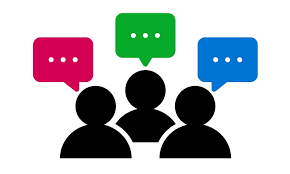

---

## **Extra: ¿Cómo puedo hacer para que el sistema conteste en Español?**


## **Extra: ¿Y podría agregarle un agente de reflexion/crítica sobre lo generado?**

In [ ]:
# TODO: Add your code here